## Match 3 Confocals to PWS
by Jacky

Here we use cell2 as an example to illustrate the matching process

In [49]:
from tifffile import tifffile
import scipy.io as scio
import numpy as np
# Load all the path information
cell= '2' # choose cell2
tif = tifffile.imread(f'Dataset\\DV\\Cell{cell}\\Cell0{cell}_R3D_D3D-processed.tif') # open tiff file in read mode
mask = scio.loadmat(f'Dataset\\DV\\Cell{cell}\\Cell0{cell}labels.mat')

tif_list = [tif[i,:,:] for i in range(tif.shape[0])] # put all images in the tif array into list
mask_list = [mask['labels'][:,:,i] for i in range(mask['labels'].shape[2])] # put all masks into list

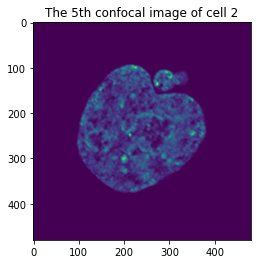

In [50]:
import matplotlib.pyplot as plt
# take the 5th image in cell2's tiff as example, which is depicted below
i=5
mask = mask_list[i]
cofocal = tif_list[i]
masked_DV = cofocal* mask
plt.imshow(masked_DV)
plt.title("The 5th confocal image of cell 2")
plt.show()

Here we read the PWS image corresponding to cell2 and compared it with all confocal images

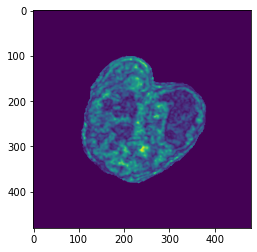

In [51]:
import cv2 as cv
from PIL import Image

path = f'.\Dataset\Results\Cell{cell}\Mapping_DV_PWS\PWS.png'
PWS = np.array(Image.open(path))
plt.imshow(PWS)
plt.show()

Here we will extract a rough shape contour of what we need by setting a threshold

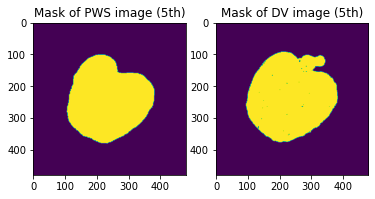

In [52]:
ret, threshPWS = cv.threshold(PWS, 0.0001, PWS.max(),0)
threshPWS=np.uint8(threshPWS>0)
plt.subplot(121)
plt.imshow(threshPWS)
plt.title('Mask of PWS image (5th)')
retDV, threshDV = cv.threshold(masked_DV, 0.0001, masked_DV.max(),0)
threshDV=np.uint8(threshDV>0)
plt.subplot(122)
plt.title('Mask of DV image (5th)')
plt.imshow(threshDV)
plt.show()

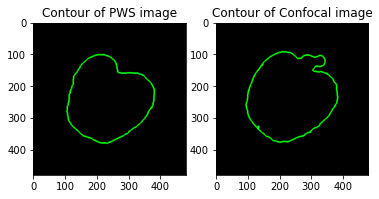

In [53]:
def find_long_cnt(contours:tuple):
    cnt_len = [cnt.shape[0] for cnt in contours]
    return np.argmax(cnt_len)

# extract the contours
contours1,hierarchy1 = cv.findContours(threshPWS,2,1)
cnt1 = contours1[find_long_cnt(contours1)]
contours2,hierarchy2 = cv.findContours(threshDV,2,1)
cnt2 = contours2[find_long_cnt(contours2)]

# Draw the contours
merge_img = cv.merge([threshPWS,threshPWS,threshPWS])
cv.drawContours(merge_img, [cnt1], 0, (0,255,0), 3)
plt.subplot(121)
plt.imshow(merge_img)
plt.title('Contour of PWS image')


merge_DV = cv.merge([threshDV,threshDV,threshDV])
cv.drawContours(merge_DV, [cnt2], 0, (0,255,0), 3)
plt.subplot(122)
plt.imshow(merge_DV)
plt.title('Contour of Confocal image')
plt.show()

As can be seen from the above figure, the contours of these two images are relatively similar, so their corresponding scores are also relatively low

In [54]:
ret = cv.matchShapes(cnt1,cnt2,1,0.0)
print(ret)

0.11703110501123892


In [55]:
def get_matching_score(PWS, DV, mask):
    """
    This function calculates the similarity between the shapes of two images.
    The smaller the value returned, the higher the similarity between the two images
    :param PWS: the PWS img
    :param DV: the confocal img
    :param mask: the confocal mask
    :return: return the matching score, the smaller, the better
    """
    masked_DV = DV * mask
    if masked_DV.max() == 0:
        return None

    # image binarization
    ret, threshPWS = cv.threshold(PWS, 0.0001, PWS.max(), 0)
    retDV, threshDV = cv.threshold(masked_DV, 10, masked_DV.max(), 0)
    threshPWS = np.uint8(threshPWS > 0)
    threshDV = np.uint8(threshDV > 0)

    # find the longest contour
    def find_long_cnt(contours: tuple):
        cnt_len = [cnt.shape[0] for cnt in contours]
        return np.argmax(cnt_len)

    # extract all possible contours from the image
    contours_PWS, hierarchy_PWS = cv.findContours(threshPWS, 2, 1)
    cnt_PWS = contours_PWS[find_long_cnt(contours_PWS)]
    contours_DV, hierarchy_DV = cv.findContours(threshDV, 2, 1)
    cnt_DV = contours_DV[find_long_cnt(contours_DV)]

    return cv.matchShapes(cnt_DV, cnt_PWS, 1, 0.0)

## Demo Process
Here we will complete the matching process, since not all confocal images have corresponding labels (beginning and end). During our processing, we confocal images without labels will have a score of "None" and will not be counted in the comparison process

### Step 1: Choose the number 1-7 for demonstration

In [56]:
cell = '7'

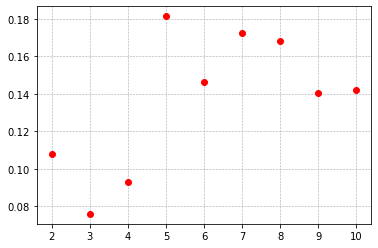

In [57]:
import heapq
from PIL import Image

DV = tifffile.imread(f'Dataset\\DV\\Cell{cell}\\Cell0{cell}_R3D_D3D-processed.tif')  # open tiff file
mask = scio.loadmat(f'Dataset\\DV\\Cell{cell}\\Cell0{cell}labels.mat')  # open mat file
pws = np.array(Image.open(f'.\Dataset\Results\Cell{cell}\Mapping_DV_PWS\PWS.png'))  # open the pws image

DV_list = [DV[i, :, :] for i in range(DV.shape[0])]  # put all image in the tiff array into list
ml = [mask['labels'][:, :, i] for i in range(mask['labels'].shape[2])]

# Here, we will plot the corresponding matching score of all DV images
score_list = []
for i in range(len(DV_list)):
    score_list.append(get_matching_score(pws, ml[i], DV_list[i]))

plt.xticks(range(len(score_list)))
plt.plot(range(len(score_list)),score_list,'o', color='red')
plt.grid(linestyle = '--', linewidth = 0.6)

In [58]:
def find_DV_ind(score_list, n:int=3)->list:
    """find the 3 least value in the output score list"""
    for i,val in enumerate(score_list):
        if val is None:
            score_list[i] = 100
    max_number = heapq.nsmallest(n, score_list)
    max_index = []
    for t in max_number:
        index = score_list.index(t)
        max_index.append(index)
        score_list[index] = 0
    return max_index

def draw_cnt(img):
    """return the contour of input image"""
    ret, thresh = cv.threshold(img, 0.00001, img.max(),0)
    thresh=np.uint8(thresh>0)
    contours,hierarchy = cv.findContours(thresh,2,1)
    cnt = contours[0]
    mi = cv.merge([thresh,thresh,thresh])
    cv.drawContours(mi, [cnt], 0, (0,255,0), 3)
    # plt.imshow(mi)
    return mi


def draw_pic(pws, pic):
    """can be ignored, just for demon"""
    plt.subplot(221)
    plt.imshow(pws)
    plt.subplot(222)
    plt.imshow(pic)
    plt.subplot(223)
    plt.imshow(draw_cnt(pws))
    plt.subplot(224)
    plt.imshow(draw_cnt(pic))
    plt.show()

### Depicting 3 most relevant confocal images

Selected Confocal index are:3


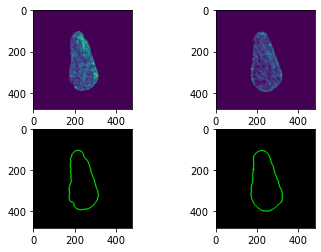

Selected Confocal index are:4


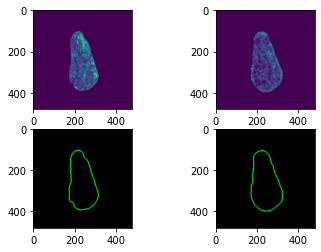

Selected Confocal index are:2


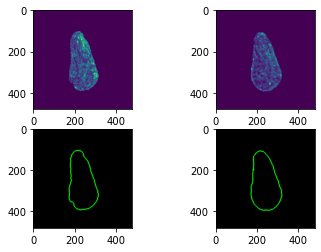

In [59]:
smallest_3 = find_DV_ind(score_list, 3)
cf_selected = []
for i in smallest_3:
    print(f"Selected Confocal index are:{i}")
    draw_pic(pws, ml[i] * DV_list[i])
    cf_selected.append(ml[i] * DV_list[i])

#### Caculate their mean value

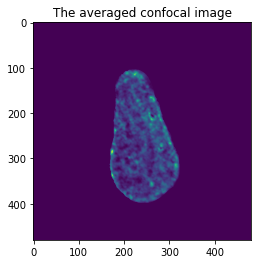

In [60]:
cf_fused = np.average(cf_selected,axis=0)
np.save(f"C:\\Users\\jacky\\Desktop\\learn\\ChromSTEM_Tomography\\data\\train\\Confocal\\cell0{cell}.npy", cf_fused)

# b = np.load(f"C:\\Users\\jacky\\Desktop\\learn\\ChromSTEM_Tomography\\data\\train\\Confocal\\cell0{cell}.npy")
# print((cf_fused==b).all())
plt.imshow(cf_fused)
plt.title('The averaged confocal image')
plt.show()